<a href="https://colab.research.google.com/github/DimitrisReppas/Analysis-and-prediction-of-stock-prices/blob/main/Deep_Learning_Project_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Project: Predicting



## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import MeanAbsolutePercentageError, MeanSquaredError, Accuracy, Precision, Recall
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.metrics import f1_score, confusion_matrix

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC,SVR
from xgboost import XGBRegressor 

### Auxilary functions

In [ ]:
def write_values(rects, ax):
  heights = [r.get_height() for r in rects]
  rel_heights = [h/max(heights) for h in heights]
  idx = heights.index(max(heights))
  for i,(r,h, rh) in enumerate(zip(rects, heights, rel_heights)):
      ax.text(r.get_x() + r.get_width()/2.0, h + max(heights) * .01, f'{h:.2}', ha='center')

def factor_int(n):
  val = math.ceil(math.sqrt(n))
  val2 = int(n/val)
  while val2 * val != float(n):
    val -= 1
    val2 = int(n/val)
  return val, val2

## Download Dataset

In [ ]:
!gdown --id 1TS-Jluy0_40MkIJkF9wUP1Xih6e1M35p
!unzip cac40.zip -d cac40

Downloading...
From: https://drive.google.com/uc?id=1TS-Jluy0_40MkIJkF9wUP1Xih6e1M35p
To: /content/cac40.zip
2.59MB [00:00, 81.0MB/s]
Archive:  cac40.zip
replace cac40/CAC40_stocks_2010_2021.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: cac40/CAC40_stocks_2010_2021.csv  
replace cac40/preprocessed_CAC40.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: cac40/preprocessed_CAC40.csv  


In [ ]:
cac40 = pd.read_csv('/content/cac40/preprocessed_CAC40.csv', 
                   usecols = ['Name','Date','Open','Closing_Price','Daily_High','Daily_Low','Volume']
                  )

## Create Dataset

In [ ]:
#Stock name encoder
name_encoder = OrdinalEncoder()
#Value scaler
scaler = MinMaxScaler(feature_range=(0,1))

feature_cols = [
                # 'Movement',
                'Closing_Price', 
                # 'Open', 'Daily_High', 'Daily_Low', "Volume", 
                # 'avg',
                # "ma7", "ma21", "ema26", "ema12", "MACD", "upper_band", "lower_band", "ema", "momentum",
                "Year", "Month", "Day", "Day of Week", "Name"]

def create_timeseries(data, lag):
  x = []
  y = []

  for i in range(lag, len(data)):
      x.append(data[i - lag:i, :])
      y.append(data[i, 0])
  
  x, y = np.array(x), np.array(y)
  x = np.reshape(x, (x.shape[0], x.shape[1], -1))

  assert len(x) == len(y)
  return x, y

def create_lag_features(data, lag):
  x = []
  y = []

  for i in range(lag, len(data)):
      x.append(data[i - lag:i, :])
      y.append(data[i, 0])
  
  x, y = np.array(x), np.array(y)
  x = np.reshape(x, (x.shape[0], -1))

  assert len(x) == len(y)
  return x, y

def create_dataset(df, lag=60, dataset_format='timeseries', stock=None, target="regression"):
  if stock:
    #Keep only one specific stock
    X = df[df['Name'] == stock].copy()
  else:
    #Keep all stocks
    X = df.copy()


  #Sort data from oldest to newest
  X = X.sort_values('Date')
  
  #Convert name from string to int
  X['Name'] = name_encoder.fit_transform(X['Name'].to_numpy().reshape(-1,1))

  #Convert volume from string to float
  X['Volume'].str.strip()
  X['Volume'] = X['Volume'].replace(',','', regex=True)
  X['Volume'] = X['Volume'].astype('float')

  #Replace NaN values
  for name, values in X.iteritems():
    if values.isnull().sum() > 0:
      X[name].interpolate(inplace=True)
  assert X.isnull().sum().sum() == 0

  #Create additional features and technical indicators
  #Average of given prices
  X['avg'] = X[['Closing_Price', 'Open', 'Daily_High', 'Daily_Low']].mean().mean()
  # Create 7 and 21 days Moving Average
  X['ma7'] = X['Closing_Price'].rolling(window = 7).mean()
  X['ma21'] = X['Closing_Price'].rolling(window = 21).mean()
  #Create MACD
  X['ema26'] = X['Closing_Price'].ewm(span=26).mean()
  X['ema12'] = X['Closing_Price'].ewm(span=12).mean()
  X['MACD'] = (X['ema12']-X['ema26'])
  #Create Bollinger Bands
  X['20sd'] = X['Closing_Price'].rolling(window = 20).std()
  X['upper_band'] = (X['Closing_Price'].rolling(window = 20).mean()) + (X['20sd']*2)
  X['lower_band'] = (X['Closing_Price'].rolling(window = 20).mean()) - (X['20sd']*2)
  #Create Exponential moving average
  X['ema'] = X['Closing_Price'].ewm(com=0.5).mean()
  #Create Momentum
  X['momentum'] = X['Closing_Price'].rolling(window=10).apply(lambda x: x.iat[-1] - x.iat[0])

  #Replace NaN values
  for name, values in X.iteritems():
    if values.isnull().sum() > 0:
      X[name].interpolate(inplace=True, limit_direction='both')
  assert X.isnull().sum().sum() == 0

  #Break day into year, month, day and day of week (e.g. Monday, etc.)
  X['Date'] = pd.to_datetime(X['Date'])
  X['Year'] = X['Date'].dt.year
  X['Month'] = X['Date'].dt.month
  X['Day'] = X['Date'].dt.day
  X['Day of Week'] = X['Date'].dt.dayofweek

  #Throw away original date column
  X = X.drop(columns=['Date'])
  year = X['Year']

  #Move target column to first column
  if target == 'regression':
    close = X.pop("Closing_Price")
    X.insert(0, "Closing_Price", close)
  elif target == 'classification':
    X['Movement'] = X['Closing_Price'].rolling(window=2).apply(lambda x: 1 if x.iat[-1] > x.iat[0] else 0)
    X['Movement'].iat[0] = 0
    movement = X.pop("Movement")
    X.insert(0, "Movement", movement)
  else:
    raise ValueError()

  #Keep only necessary features
  X = pd.DataFrame(X, columns=feature_cols)

  # Normalize data
  if scaler != None:
    X = scaler.fit_transform(X)
  else:
    X = X.to_numpy()

  #Split into train, test
  train_points = year < 2019
  train_data = X[train_points]
  
  test_points = year >= 2019
  test_points.iloc[test_points.argmax()-lag:] = True
  test_data = X[test_points]

  if dataset_format == 'timeseries':
    X_train, y_train = create_timeseries(train_data, lag)
    X_test, y_test = create_timeseries(test_data, lag)
  elif dataset_format == 'lag_features':
    X_train, y_train = create_lag_features(train_data, lag)
    X_test, y_test = create_lag_features(test_data, lag)

  return (X_train, y_train), (X_test, y_test)


def next_day(row):
  year, month, day = round(row['Year'].item()), round(row['Month'].item()), round(row['Day'].item())
  new_date = pd.Timestamp(year=year, month=month, day=day)
  new_date += pd.Timedelta(days=3 if int(row['Day of Week'].item()) == 4 else 1)
  return new_date

def dataset_to_df(X, Y, lag=60):
  if X.ndim == 3:
    last_days = X[:, -1, :]
  elif X.ndim == 2:
    n_feat = int(X.shape[1]/lag)
    last_days = X[:, -n_feat:]
  new_df = pd.DataFrame(last_days, columns=feature_cols)
  #Replace closing price with y and scale back to original values
  new_df['Closing_Price'] = Y
  if scaler != None:
    new_df = pd.DataFrame(scaler.inverse_transform(new_df), columns=feature_cols)
  #Go to next day (i.e. day of the prediction)
  new_df['Date'] = new_df.apply(next_day, axis=1)
  #Convert name to string
  new_df["Name"] = name_encoder.inverse_transform(new_df["Name"].to_numpy().reshape(-1, 1))

  return pd.DataFrame(new_df, columns=['Name', "Date", "Closing_Price"])

In [ ]:
(X_train, y_train), (X_test, y_test) = create_dataset(cac40, stock="TOTAL")
# (X_train, y_train), (X_test, y_test) = create_dataset(cac40)
# (X_train, y_train), (X_test, y_test) = create_dataset(cac40, dataset_format="lag_features", stock="TOTAL")
# (X_train, y_train), (X_test, y_test) = create_dataset(cac40, stock="TOTAL", dataset_format="lag_features", target="classification")

print(f"X_train: {str(X_train.shape):14}, y_train: {y_train.shape}")
print(f"X_test:  {str(X_test.shape):14}, y_test:   {y_test.shape}")

X_train: (2223, 60, 6) , y_train: (2223,)
X_test:  (318, 60, 6)  , y_test:   (318,)


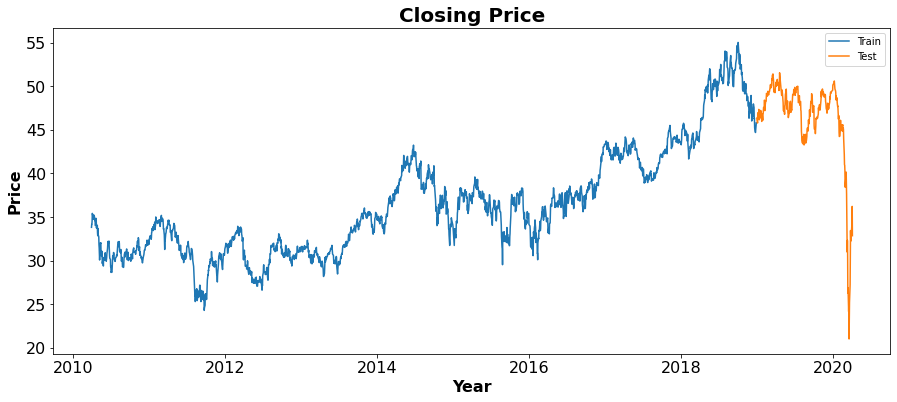

In [ ]:
train_df = dataset_to_df(X_train, y_train)
test_df = dataset_to_df(X_test, y_test)

# Line plot
fig, ax = plt.subplots(figsize=(15, 6))

plt.plot(train_df['Date'], train_df['Closing_Price'], label="Train")
plt.plot(test_df['Date'], test_df['Closing_Price'], label="Test")

# Formatting
ax.set_title('Closing Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
ax.legend()
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

## Predicting prices with regression

In [ ]:
results = {}
target = "regression"

#The following variables can be changed to alter the experiment

#Value scaler can be set to None for no scaling
scaler = MinMaxScaler(feature_range=(0,1))
# scaler = None

feature_cols = [
                'Closing_Price', 
                'Open', 'Daily_High', 'Daily_Low', "Volume", 
                'avg',
                # "ma7", "ma21", "ema26", "ema12", "MACD", "upper_band", "lower_band", "ema", "momentum",
                "Year", "Month", "Day", "Day of Week", "Name"]
lag = 30
stock_name = "TOTAL"

### Classic models

In [ ]:
model_create_funcs = {
    "Linear Regr." : (LinearRegression, "lag_features"), 
    "XGB" : (XGBRegressor, "lag_features"),
    "SVM" : (SVR, "lag_features"),
}

for name, (create_func, dataset_format) in model_create_funcs.items():
  #Create dataset
  (X_train, y_train), (X_test, y_test) = create_dataset(cac40, lag=lag, dataset_format=dataset_format, stock=stock_name, target=target)
  #Create model
  model = create_func()
  #Train model
  model.fit(X_train, y_train)

  #Make predictions on test set
  predicted_prices = model.predict(X_test)
  #Convert predictions
  pred_df = dataset_to_df(X_test, predicted_prices, lag=lag)
  #Get metrics on test set
  mse = MeanSquaredError()(predicted_prices, y_test)
  mape = MeanAbsolutePercentageError()(predicted_prices, y_test) 

  #Make predictions on train set
  predicted_prices = model.predict(X_train)
  #Get metrics on train set
  train_mse = MeanSquaredError()(predicted_prices, y_train)
  train_mape = MeanAbsolutePercentageError()(predicted_prices, y_train) 

  results[name] = {
      "pred" : pred_df,
      "mse" : mse,
      "mape" : mape,
      "train_mse" : train_mse,
      "train_mape" : train_mape
  }


[15:19:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### Neural models

#### Define models

In [ ]:
def LSTM_model(inp_shape):
  model = Sequential()
  model.add(LSTM(32, input_shape=(inp_shape), return_sequences = True))
  model.add(LSTM(16))
  model.add(Dense(1))
  model.add(Activation('relu'))
  return model

def BiLSTM_model(inp_shape):
  model = Sequential()
  model.add(Bidirectional(LSTM(32, input_shape=(inp_shape), return_sequences = True)))
  model.add(Bidirectional(LSTM(16)))
  model.add(Dense(1))
  model.add(Activation('relu'))

  return model

def GRU_model(inp_shape):
  model = Sequential()
  model.add(GRU(32, input_shape=(inp_shape), return_sequences = True))
  model.add(GRU(16))
  model.add(Dense(1))
  model.add(Activation('relu'))

  return model

def BiGRU_model(inp_shape):
  model = Sequential()
  model.add(Bidirectional(GRU(32, input_shape=(inp_shape), return_sequences = True)))
  model.add(Bidirectional(GRU(16)))
  model.add(Dense(1))
  model.add(Activation('relu'))
  return model


def Linear_model(inp_shape):
  model = Sequential()
  model.add(Dense(128,input_shape = inp_shape))
  model.add(Dense(32))
  model.add(Dense(1))
  model.add(Activation('relu'))
  return model

#### Train models

In [ ]:
model_create_funcs = {
    "LSTM" : (LSTM_model, "timeseries"),
    "Bi-LSTM" : (BiLSTM_model, "timeseries"),
    "Bi-GRU" : (BiGRU_model, "timeseries"),
    "GRU" : (GRU_model, "timeseries"), 
    "Linear" : (Linear_model, "lag_features"),    
}

for name, (create_func, dataset_format) in model_create_funcs.items():
  #Create dataset
  (X_train, y_train), (X_test, y_test) = create_dataset(cac40, lag=lag, dataset_format=dataset_format, stock=stock_name, target=target)
  #Create model
  if X_train.ndim == 3:
    model = create_func((X_train.shape[1], X_train.shape[2]))
  elif X_train.ndim == 2:
    model = create_func((X_train.shape[1],))
  # model.summary()
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_percentage_error'])

  #Define callbacks
  early_stopper = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
  cbs = [early_stopper]

  #Train model
  model.fit(X_train, y_train, validation_split=0.1, epochs=40, batch_size=1, verbose=1, callbacks=cbs)

  #Make predictions on test set
  predicted_prices = model.predict(X_test)
  #Convert predictions
  pred_df = dataset_to_df(X_test, predicted_prices, lag=lag)
  #Get metrics on test set
  mse = MeanSquaredError()(predicted_prices, y_test)
  mape = MeanAbsolutePercentageError()(predicted_prices, y_test) 
  #Make predictions on train set
  predicted_prices = model.predict(X_train)
  #Get metrics on train set
  train_mse = MeanSquaredError()(predicted_prices, y_train)
  train_mape = MeanAbsolutePercentageError()(predicted_prices, y_train)

  results[name] = {
      "pred" : pred_df,
      "mse" : mse,
      "mape" : mape,
      "train_mse" : mse,
      "train_mape" : mape
  }

Epoch 1/40
2027/2027 [==============================] - 37s 17ms/step - loss: 0.0029 - mean_absolute_percentage_error: 9.0658 - val_loss: 0.0016 - val_mean_absolute_percentage_error: 3.7991
Epoch 2/40
2027/2027 [==============================] - 33s 16ms/step - loss: 7.5213e-04 - mean_absolute_percentage_error: 5.8914 - val_loss: 0.0023 - val_mean_absolute_percentage_error: 4.8755
Epoch 3/40
2027/2027 [==============================] - 34s 17ms/step - loss: 5.6215e-04 - mean_absolute_percentage_error: 5.0500 - val_loss: 5.6252e-04 - val_mean_absolute_percentage_error: 2.3539
Epoch 4/40
2027/2027 [==============================] - 34s 17ms/step - loss: 4.0499e-04 - mean_absolute_percentage_error: 4.2937 - val_loss: 5.1800e-04 - val_mean_absolute_percentage_error: 2.1411
Epoch 5/40
2027/2027 [==============================] - 34s 17ms/step - loss: 3.9384e-04 - mean_absolute_percentage_error: 4.2453 - val_loss: 0.0030 - val_mean_absolute_percentage_error: 5.7429
Epoch 6/40
2027/2027 [====

### Plot results

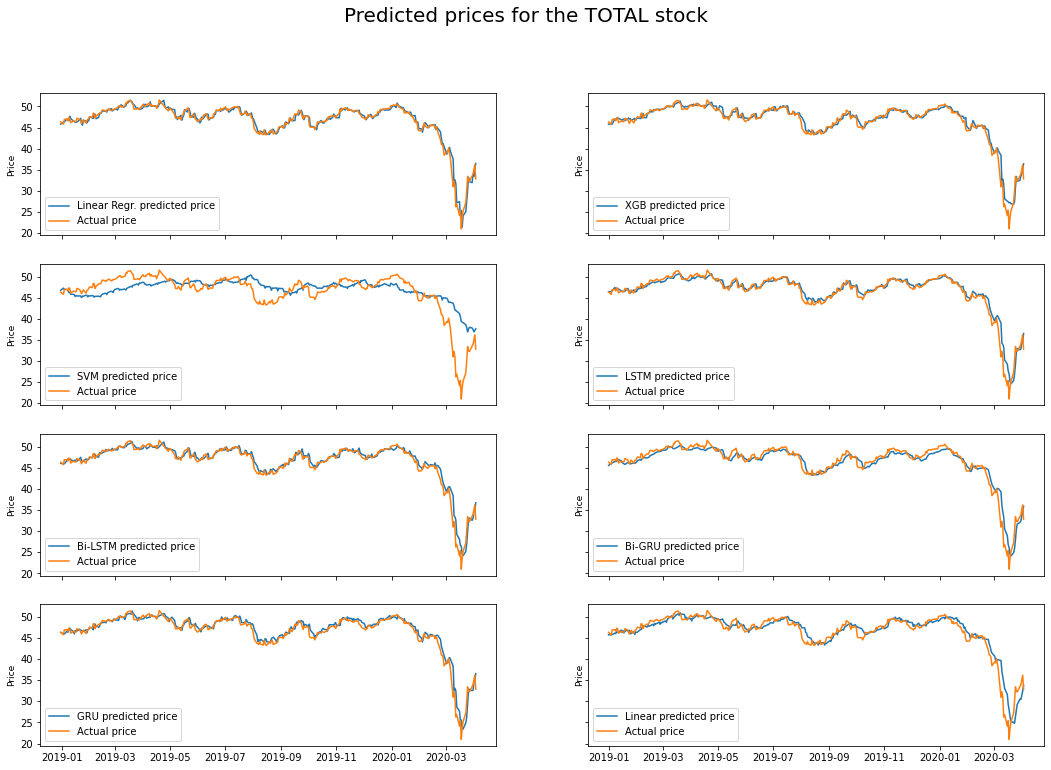

In [ ]:
#Line Plot
ncols, nrows = factor_int(len(results))
fig, axes = plt.subplots(nrows, ncols, figsize=(9*ncols, 3*nrows), sharex=True, sharey=True)

#Get actual prices
real_df = dataset_to_df(X_test, y_test, lag=lag)
if stock_name != None:
  real_df = real_df[real_df["Name"] == stock_name]

for (name, res), ax in zip(results.items(), axes.flatten()):
  #Plot predictions
  pred_df = results[name]['pred']
  if stock_name != None:
    pred_df = pred_df[real_df["Name"] == stock_name]
  ax.plot(pred_df['Date'], pred_df['Closing_Price'], label=f"{name} predicted price")
  #Plot actual prices
  ax.plot(real_df['Date'], real_df['Closing_Price'], label="Actual price")
  #Plot formatting
  ax.legend()
  ax.set_ylabel('Price', fontsize = 9)

#Figure Formatting
fig.suptitle(f'Predicted prices for the {stock_name} stock', fontsize = 20, fontdict=dict(weight='bold'))
fig.show()

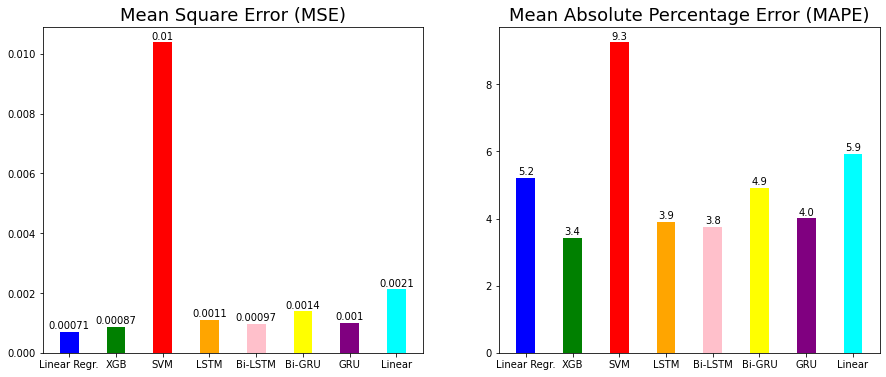

In [ ]:
methods = []
mse_scores = []
mape_scores = []

colors = ['blue', 'green', 'red', 'orange', 'pink', 'yellow', 'purple', 'cyan']

for name, res in results.items():
  #Plot scores
  methods.append(name)
  mse_scores.append(results[name]['mse'])
  mape_scores.append(results[name]['mape'])
  

#Bar Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
x = np.arange(len(results)) + 0.3
bar_width = 0.4

rects = ax1.bar(x, mse_scores, bar_width, color=colors)
write_values(rects, ax1)

rects = ax2.bar(x, mape_scores, bar_width, color=colors)
write_values(rects, ax2)

#Plot Formatting
ax1.set_title('Mean Square Error (MSE)', fontsize = 18, loc='center')
ax1.set_xticks(x)
ax1.set_xticklabels(results.keys())

ax2.set_title('Mean Absolute Percentage Error (MAPE)', fontsize = 18, loc='center')
ax2.set_xticks(x)
ax2.set_xticklabels(results.keys())
fig.show()

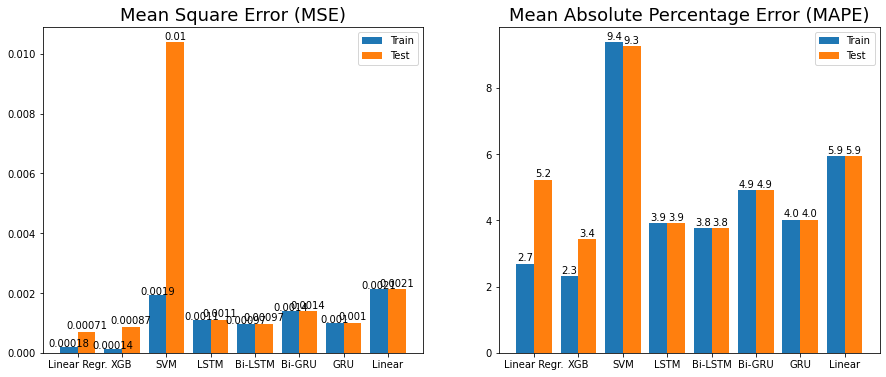

In [ ]:
methods = []
mse_scores = []
train_mse_scores = []
mape_scores = []
train_mape_scores = []

#Bar Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
x = np.arange(len(results)) + 0.3
bar_width = 0.4

for name, res in results.items():
  methods.append(name)
  mse_scores.append(results[name]['mse'])
  mape_scores.append(results[name]['mape'])
  train_mse_scores.append(results[name]['train_mse'])
  train_mape_scores.append(results[name]['train_mape'])

rects = ax1.bar(x - bar_width/2, train_mse_scores, width=bar_width, label="Train")
write_values(rects, ax1)

rects = ax1.bar(x + bar_width/2, mse_scores, width=bar_width, label="Test")
write_values(rects, ax1)

rects = ax2.bar(x - bar_width/2, train_mape_scores, width=bar_width, label="Train")
write_values(rects, ax2)

rects = ax2.bar(x + bar_width/2, mape_scores, width=bar_width, label="Test")
write_values(rects, ax2)

#Plot Formatting
ax1.set_title('Mean Square Error (MSE)', fontsize = 18, loc='center')
ax1.set_xticks(x)
ax1.set_xticklabels(methods)
ax1.legend()

ax2.set_title('Mean Absolute Percentage Error (MAPE)', fontsize = 18, loc='center')
ax2.set_xticks(x)
ax2.set_xticklabels(methods)
ax2.legend()

fig.show()

## Predicting price movement with classification

In [ ]:
results = {}
target = "classification"

#The following variables can be changed to alter the experiment

#Value scaler can be set to None for no scaling
scaler = MinMaxScaler(feature_range=(0,1))
# scaler = None

feature_cols = [
                'Movement',
                'Closing_Price', 
                'Open', 'Daily_High', 'Daily_Low', "Volume", 
                'avg',
                # "ma7", "ma21", "ema26", "ema12", "MACD", "upper_band", "lower_band", "ema", "momentum",
                "Year", "Month", "Day", "Day of Week", "Name"]

lag = 60
stock_name = "Accor"

### Classic Models

In [ ]:
model_create_funcs = {
    "Logistic Regr." : (LogisticRegression(random_state=0, max_iter=1000), "lag_features"), 
    "RFC" : (RandomForestClassifier(max_depth=10,n_estimators=150), "lag_features"),
    "SVM" : (SVC(C=1, kernel='poly', degree=2, probability=True), "lag_features"),
}

for name, (model, dataset_format) in model_create_funcs.items():
  #Create dataset
  (X_train, y_train), (X_test, y_test) = create_dataset(cac40, lag=lag, dataset_format=dataset_format, stock=stock_name, target=target)
  
  #Train model
  model.fit(X_train, y_train)

  #Make predictions on test set
  predicted_prices = model.predict(X_test) > 0.5
  #Get metrics on test set
  acc = Accuracy()(predicted_prices, y_test)
  prec = Precision()(predicted_prices, y_test) 
  rec = Recall()(predicted_prices, y_test)
  f1 = f1_score(y_test, predicted_prices) 
  #Confusion matrix
  conf_m = confusion_matrix(y_test, predicted_prices)

  #Make predictions on train set
  predicted_prices = model.predict(X_train) > 0.5
  #Get metrics on train set
  train_acc = Accuracy()(predicted_prices, y_train)
  train_prec = Precision()(predicted_prices, y_train) 
  train_rec = Recall()(predicted_prices, y_train)
  train_f1 = f1_score(y_train, predicted_prices)


  results[name] = {
      # "pred" : pred_df,
      "acc" : acc,
      "prec" : prec,
      "rec" : rec,
      "f1" : f1,
      "train_acc" : train_acc,
      "train_prec" : train_prec,
      "train_rec" : train_rec,
      "train_f1" : train_f1,
      "conf_m" : conf_m,
  }


### Neural Models

#### Define models

In [ ]:
def LSTM_model(inp_shape):
  model = Sequential()
  model.add(LSTM(32, input_shape=(inp_shape), return_sequences = True))
  model.add(LSTM(16))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  return model

def BiLSTM_model(inp_shape):
  model = Sequential()
  model.add(Bidirectional(LSTM(32, input_shape=(inp_shape), return_sequences = True)))
  model.add(Bidirectional(LSTM(16)))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  return model

def GRU_model(inp_shape):
  model = Sequential()
  model.add(GRU(32, input_shape=(inp_shape), return_sequences = True))
  model.add(GRU(16))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  return model

def BiGRU_model(inp_shape):
  model = Sequential()
  model.add(Bidirectional(GRU(32, input_shape=(inp_shape), return_sequences = True)))
  model.add(Bidirectional(GRU(16)))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  return model


def Linear_model(inp_shape):
  model = Sequential()
  model.add(Dense(128,input_shape = inp_shape))
  #model.add(Dropout(0.2))
  model.add(Dense(32))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  return model

#### Train models

In [ ]:
model_create_funcs = {
    # "LSTM" : (LSTM_model, "timeseries"),
    # "Bi-LSTM" : (BiLSTM_model, "timeseries"),
    # "Bi-GRU" : (BiGRU_model, "timeseries"),
    "GRU" : (GRU_model, "timeseries"), 
    # "Linear" : (Linear_model, "lag_features"),    
}

for name, (create_func, dataset_format) in model_create_funcs.items():
  #Create dataset
  (X_train, y_train), (X_test, y_test) = create_dataset(cac40, lag=lag, dataset_format=dataset_format, stock=stock_name, target=target)
  #Create model
  if X_train.ndim == 3:
    model = create_func((X_train.shape[1], X_train.shape[2]))
  elif X_train.ndim == 2:
    model = create_func((X_train.shape[1],))
  # model.summary()
  model.compile(optimizer=Adam(learning_rate=1e-5, decay=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

  #Define callbacks
  early_stopper = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
  cbs = [early_stopper]

  #Train model
  model.fit(X_train, y_train, validation_split=0.1, epochs=25, batch_size=32, verbose=1, callbacks=cbs)

  #Make predictions on test set
  predicted_prices = model.predict(X_test) > 0.5
  #Get metrics on test set
  acc = Accuracy()(predicted_prices, y_test)
  prec = Precision()(predicted_prices, y_test) 
  rec = Recall()(predicted_prices, y_test)
  f1 = f1_score(y_test, predicted_prices) 
  #Confusion matrix
  conf_m = confusion_matrix(y_test, predicted_prices)

  #Make predictions on train set
  predicted_prices = model.predict(X_train) > 0.5
  #Get metrics on train set
  train_acc = Accuracy()(predicted_prices, y_train)
  train_prec = Precision()(predicted_prices, y_train) 
  train_rec = Recall()(predicted_prices, y_train)
  train_f1 = f1_score(y_train, predicted_prices)

  results[name] = {
      # "pred" : pred_df,
      "acc" : acc,
      "prec" : prec,
      "rec" : rec,
      "f1" : f1,
      "train_acc" : train_acc,
      "train_prec" : train_prec,
      "train_rec" : train_rec,
      "train_f1" : train_f1,
      "conf_m" : conf_m,
  }

### Plot Results

In [ ]:
methods = []
acc_scores = []
f1_scores = []

colors = ['blue', 'green', 'red', 'orange', 'pink', 'yellow', 'purple', 'cyan']

for name, res in results.items():
  #Plot scores
  methods.append(name)
  acc_scores.append(results[name]['acc'])
  f1_scores.append(results[name]['f1'])
  

#Bar Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
index = np.arange(len(results))
bar_width = 0.4

rects = ax1.bar(methods, acc_scores, bar_width, color=colors)
write_values(rects, ax1)

rects = ax2.bar(methods, f1_scores, bar_width, color=colors)
write_values(rects, ax2)


#Plot Formatting
ax1.set_title('Accuracy', fontsize = 18, loc='center')
ax2.set_title('F1 Score', fontsize = 18, loc='center')
fig.show()

In [ ]:
ncols, nrows = factor_int(len(results))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), sharex=True, sharey=True)
# plt.style.use('ggplot')
# sns.set(font_scale=1.2)

for (name, res), ax in zip(results.items(), axes.flatten()):
  conf_m = res['conf_m']
  sns.heatmap(conf_m, annot=True,xticklabels=['UP', 'DOWN'], yticklabels=['UP', 'DOWN'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f', ax=ax)

  # ax.set_yticks(rotation=0)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  # ax.xaxis.set_ticks_position('top') 
  ax.set_title(f'{name}')

fig.show()

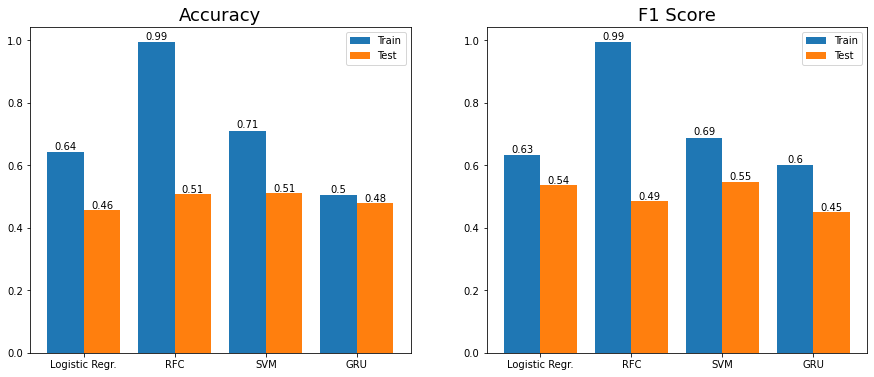

In [ ]:
methods = []
acc_scores = []
train_acc_scores = []
f1_scores = []
train_f1_scores = []

#Bar Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
x = np.arange(len(results)) + 0.3
bar_width = 0.4

for name, res in results.items():
  methods.append(name)
  acc_scores.append(res['acc'])
  f1_scores.append(res['f1'])
  train_acc_scores.append(res['train_acc'])
  train_f1_scores.append(res['train_f1'])

rects = ax1.bar(x - bar_width/2, train_acc_scores, width=bar_width, label="Train")
write_values(rects, ax1)

rects = ax1.bar(x + bar_width/2, acc_scores, width=bar_width, label="Test")
write_values(rects, ax1)

rects = ax2.bar(x - bar_width/2, train_f1_scores, width=bar_width, label="Train")
write_values(rects, ax2)

rects = ax2.bar(x + bar_width/2, f1_scores, width=bar_width, label="Test")
write_values(rects, ax2)

#Plot Formatting
ax1.set_title('Accuracy', fontsize = 18, loc='center')
ax1.set_xticks(x)
ax1.set_xticklabels(methods)
ax1.legend()

ax2.set_title('F1 Score', fontsize = 18, loc='center')
ax2.set_xticks(x)
ax2.set_xticklabels(methods)
ax2.legend()

fig.show()